In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import utils

In [2]:
fdata = sc.read_h5ad("/home/wpy/stereoseq/20240502-SPACseq/RNA/Multitime.clustered.h5")
gdata = sc.read_h5ad("/home/wpy/stereoseq/20240502-SPACseq/RNA/Multitime.filtered.guide.bin100.h5")

gdata.obs.marker = gdata.obs.marker.map({
    'B926-1': '2-1',
    'B926-2': '2-2',
    'B924-1': '1-1',
    'B924-2': '1-2',
    'B922-1': '3-1',
    'B922-2': '3-2'
})

fdata.obs['coord_x'] = fdata.obsm['spatial'][:, 0] // 100 * 100

fdata.obs['coord_y'] = fdata.obsm['spatial'][:, 1] // 100 * 100

gdata.obs['coord_x'] = gdata.obsm['spatial'][:, 0] // 100 * 100
gdata.obs['coord_y'] = gdata.obsm['spatial'][:, 1] // 100 * 100
fdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(fdata.obs['marker'], fdata.obs['coord_x'], fdata.obs['coord_y'])]
gdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(gdata.obs['marker'], gdata.obs['coord_x'], gdata.obs['coord_y'])]

common_bins = np.intersect1d(fdata.obs_names, gdata.obs_names)
fdata = fdata[common_bins].copy()
gdata = gdata[common_bins].copy()

gdata = utils.combine_guide_replicates(gdata)

/home/wpy/stereoseq/20240822-Pipeline/utils.py:88: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


# Segment samples

In [3]:
# 创建一个字典来存储不同marker和不同采样率的数据
downsampled_data = {}

# 获取所有唯一的marker
markers = np.unique(fdata.obs.marker)

# 对每个marker进行处理
for marker in markers:
    # 获取当前marker的数据
    f_marker = fdata[fdata.obs.marker == marker].copy()
    g_marker = gdata[gdata.obs.marker == marker].copy()
    
    # 获取总bin数量
    n_bins = len(f_marker)
    
    # 对不同的采样率进行处理
    for rate in [0.2, 0.4, 0.6, 0.8]:  # 1/5, 2/5, 3/5, 4/5
        # 计算需要采样的bin数量
        n_sample = int(n_bins * rate)
        
        # 随机选择bin的索引
        np.random.seed(42)  # 设置随机种子以保证结果可重复
        selected_idx = np.random.choice(n_bins, n_sample, replace=False)
        
        # 获取采样后的数据
        f_sampled = f_marker[selected_idx].copy()
        g_sampled = g_marker[selected_idx].copy()
        
        # 将结果存储在字典中
        key = (marker, rate)
        downsampled_data[key] = {
            'feature': f_sampled,
            'guide': g_sampled
        }

In [5]:
for marker in markers:
    downsampled_data[(marker, 1.0)] = {
        'feature': fdata[fdata.obs.marker == marker].copy(),
        'guide': gdata[gdata.obs.marker == marker].copy()
    }

In [8]:
import pickle
pickle.dump(downsampled_data, open('./downsample_bin.pickle', 'wb'))

In [3]:
downsampled_data = {}
n_bins = len(fdata)
for rate in [0.2, 0.4, 0.6, 0.8]:
    n_sample = int(n_bins * rate)
    np.random.seed(42)
    selected_idx = np.random.choice(n_bins, n_sample, replace=False)

    f_sampled = fdata[selected_idx].copy()
    g_sampled = gdata[selected_idx].copy()

    downsampled_data[rate] = {
        'feature': f_sampled,
        'guide': g_sampled
    }

In [4]:
downsampled_data[1.0] = {
    'feature': fdata,
    'guide': gdata
}

# Benchmark time - Local mode

In [5]:
import time
import multiprocessing

def parallel_run_with_time(func, args_list, n_processes=None):
    start_time = time.time()
    
    with multiprocessing.Pool(n_processes) as pool:
        results = pool.starmap(func, args_list)
    
    end_time = time.time()
    total_time = end_time - start_time
    
    return total_time, results

# 示例函数
def example_task(x, y):
    return x + y

# 示例参数列表
args_list = [(1, 2), (3, 4), (5, 6)]

# 测试并行任务的总CPU时间
total_time, results = parallel_run_with_time(example_task, args_list, n_processes=3)
print(f"Total CPU time: {total_time} seconds")
print(f"Results: {results}")

Total CPU time: 1.2156479358673096 seconds
Results: [3, 7, 11]


In [7]:
from scipy.spatial.distance import euclidean
from tqdm import tqdm
import random

def aitchison_func(gdata, fdata):
    df = pd.DataFrame()
    for marker in gdata.obs.marker.unique():
        mdata = gdata[gdata.obs.marker == marker]
        mdata.obs['cluster'] = fdata[fdata.obs.marker == marker].obs.cluster_cellcharter_givenk.tolist()
        c_df = pd.concat([pd.DataFrame(mdata.X, columns=mdata.var_names, index=mdata.obs_names), mdata.obs.cluster], axis=1)
        c_df = c_df.groupby(['cluster']).sum().unstack().unstack()

        g_df = c_df.apply(lambda x: 10 ** (np.log10(x + 1) - (np.log10(x + 1).sum() / 12)), axis=1)
        dist = g_df.apply(lambda x: euclidean(x, g_df.loc['sgnon-targeting']), axis=1).values
        plot_df = pd.DataFrame(dist, index=g_df.index, columns=['distance']).sort_values(by='distance', ascending=False)
        df = pd.concat([df, plot_df], axis=1)
    df.columns = gdata.obs.marker.unique()

    for col in df.columns:
        non_nan_mask = df[col].notna()
        df.loc[non_nan_mask, col + '_rank'] = df.loc[non_nan_mask, col].rank(ascending=False)
        df.loc[~non_nan_mask, col + '_rank'] = np.nan

    # 计算每行非NaN的rank的平均值
    rank_cols = df.columns[df.columns.str.endswith('rank')]
    df['rank_mean'] = df[rank_cols].mean(axis=1, skipna=True)  # skipna=True会忽略NaN值计算平均数
    # df.rank_mean.sort_values().head()
    df_base = df.copy()
    # df_base.sort_values('rank_mean', ascending=True).head(2)
    df_base

    for _ in tqdm(range(1000)):
        df = pd.DataFrame()
        for marker in gdata.obs.marker.unique():
            results = {}
            for guide in gdata.var_names:
                if guide == 'sgnon-targeting': continue
                p_guide_cnts = c_df.loc[guide].copy()
                p_ntc_cnts = c_df.loc['sgnon-targeting'].copy()
                for j in range(12):
                    if random.random() < 0.5:
                        p_guide_cnts[j], p_ntc_cnts[j] = p_ntc_cnts[j], p_guide_cnts[j]
                p_data = np.vstack([10 ** (np.log10(p_guide_cnts + 1) - (np.log10(p_guide_cnts + 1).sum() / 12)),
                                    10 ** (np.log10(p_ntc_cnts + 1) - (np.log10(p_ntc_cnts + 1).sum() / 12))])
                dist = euclidean(p_data[0], p_data[1])
                results[guide] = dist
            df = pd.concat([df, pd.DataFrame(results, index=[marker]).T], axis=1)
        for col in df.columns:
            non_nan_mask = df[col].notna()
            df.loc[non_nan_mask, col + '_rank'] = df.loc[non_nan_mask, col].rank(ascending=False)
            df.loc[~non_nan_mask, col + '_rank'] = np.nan

        rank_cols = df.columns[df.columns.str.endswith('rank')]
        df['rank_mean'] = df[rank_cols].mean(axis=1, skipna=True)
    return

In [8]:
rates = [0.2, 0.4, 0.6, 0.8, 1.0]

run_times = {}
for rate in tqdm(rates):
    run_times[rate] = []
    gdata_sub = downsampled_data[rate]['guide']
    fdata_sub = downsampled_data[rate]['feature']
        
    run_times[rate].append(parallel_run_with_time(aitchison_func, [(gdata_sub, fdata_sub)], n_processes=20))
run_times

  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_77236/1909199846.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  mdata.obs['cluster'] = fdata[fdata.obs.marker == marker].obs.cluster_cellcharter_givenk.tolist()
/tmp/ipykernel_77236/1909199846.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  mdata.obs['cluster'] = fdata[fdata.obs.marker == marker].obs.cluster_cellcharter_givenk.tolist()
/tmp/ipykernel_77236/1909199846.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  mdata.obs['cluster'] = fdata[fdata.obs.marker == marker].obs.cluster_cellcharter_givenk.tolist()
/tmp/ipykernel_77236/1909199846.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  mdata.obs['cluster'] = fdata[fdata.obs.marker == marker].obs.cluster_cellcharter_givenk.tolist()
/tmp/ipyker

{0.2: [(230.53460097312927, [None])],
 0.4: [(239.71829557418823, [None])],
 0.6: [(260.0797984600067, [None])],
 0.8: [(272.427374124527, [None])],
 1.0: [(281.1048073768616, [None])]}

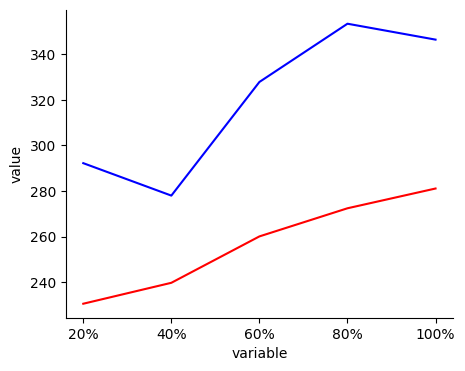

In [104]:
df = pd.DataFrame()
plt.figure(figsize=(5, 4))
df = pd.DataFrame({
    'variable': [1.0, 0.8, 0.6, 0.4, 0.2],
    'value': [281.1048073768616, 272.427374124527, 260.0797984600067, 239.71829557418823, 230.53460097312927] # copied from above
})
cdf = pd.DataFrame({
    'variable': [1.0, 0.8, 0.6, 0.4, 0.2]
})
sns.lineplot(df, x='variable', y='value', err_style='bars', color='red')
sns.lineplot(cdf, x='variable', y='value', err_style='bars', color='blue')
sns.despine()
# plt.gca().invert_xaxis()
plt.xticks([0.2, 0.4, 0.6, 0.8, 1.0], ['20%', '40%', '60%', '80%', '100%'])

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./supplementary_images/Local_runtime.pdf', bbox_inches='tight')

In [10]:
from ast import Continue
import warnings
from tqdm import tqdm
from skbio.stats.distance import permanova, DistanceMatrix
from scipy.spatial.distance import pdist, squareform
from scipy.stats import gaussian_kde
import random

def permanova_func(gdata, fdata):
    N_PERMUTE = 1000

    gdata.obs['cluster'] = fdata.obs.cluster_cellcharter_givenk.tolist()
    for marker in gdata.obs.marker.cat.categories:
        mdata = gdata[gdata.obs.marker == marker]
        c_df = pd.concat([pd.DataFrame(mdata.X, columns=mdata.var_names, index=mdata.obs_names), mdata.obs.cluster], axis=1)
        c_df = c_df.groupby(['cluster']).sum().unstack().unstack().T

    p_value = {}
    p_value_permute = {}
    for guide in tqdm(gdata.var_names):
        if guide == 'sgnon-targeting': Continue

        df = pd.DataFrame(index=range(12))
        g_df = c_df[[guide, "sgnon-targeting", "cluster"]]

        guide_df = g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting']
        guide_cnts = df.copy()
        max_count = guide_df.columns.max()
        x_grid = np.linspace(0, max_count + 0.5, 10)
        
        guide_cnts = []
        for cluster in range(12):
            if cluster in guide_df.index:
                counts = guide_df.loc[cluster].dropna()
                kde = gaussian_kde(counts)
                density = kde(x_grid)
                density = density / density.sum()
                guide_cnts.append(density)
            else:
                guide_cnts.append(np.zeros_like(x_grid))
        guide_cnts = np.array(guide_cnts)

        ntc_df = g_df.groupby(['cluster', 'sgnon-targeting']).count().unstack()[guide]
        ntc_cnts = df.copy()
        max_count = ntc_df.columns.max()
        x_grid = np.linspace(0, max_count + 0.5, 10)
        
        ntc_cnts = []
        for cluster in range(12):
            if cluster in ntc_df.index:
                counts = ntc_df.loc[cluster].dropna()
                kde = gaussian_kde(counts)
                density = kde(x_grid)
                density = density / density.sum()
                ntc_cnts.append(density)
            else:
                ntc_cnts.append(np.zeros_like(x_grid))
                
        ntc_cnts = np.array(ntc_cnts)

        data = np.vstack([guide_cnts, ntc_cnts])
        sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

        dist_matrix = squareform(pdist(data, metric='braycurtis'))
        metadata = pd.DataFrame({
            'group': ['A'] * 12 + ['B'] * 12
        }, index=sample_ids)
        dm = DistanceMatrix(dist_matrix, ids=sample_ids)

        results = permanova(dm, metadata, column='group', permutations=1000)
        p_value[guide] = results['p-value']


        p_value_permute[guide] = []
        for _ in range(N_PERMUTE):
            p_guide_cnts = guide_cnts.copy()
            p_ntc_cnts = ntc_cnts.copy()
            for j in range(12):
                if random.random() < 0.5:
                    exchange_row = p_guide_cnts[j]
                    p_guide_cnts[j] = p_ntc_cnts[j]
                    p_ntc_cnts[j] = exchange_row

            p_data = np.vstack([p_guide_cnts, p_ntc_cnts])
            p_sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

            p_dist_matrix = squareform(pdist(p_data, metric='braycurtis'))
            p_metadata = pd.DataFrame({
                'group': ['A'] * 12 + ['B'] * 12
            }, index=p_sample_ids)
            p_dm = DistanceMatrix(p_dist_matrix, ids=p_sample_ids)
            p_results = permanova(p_dm, p_metadata, column='group', permutations=100)
            p_value_permute[guide].append(p_results['p-value'])

# Benchmark time - Global mode

In [23]:
del downsampled_data

In [24]:
import pickle
downsampled_data = pickle.load(open('./downsample_bin.pickle', 'rb'))

In [37]:
from tqdm import tqdm
from numba import jit
import numpy as np
from multiprocessing import Pool
import functools

@jit(nopython=True)
def _kl_divergence(pk, qk):
    """Compute KL divergence between two probability distributions"""
    return np.sum(np.where(pk > 0, pk * (np.log(pk) - np.log(qk)), 0))

@jit(nopython=True) 
def permute_guide_bins(guide_matrix, idx_guide, idx_ntc):
    """Permute guide and non-targeting control bins"""
    t_bins = np.ones(guide_matrix.shape[0], dtype=np.bool_)
    guide_vec = guide_matrix[t_bins, idx_guide].copy()
    ntc_vec = guide_matrix[t_bins, idx_ntc].copy()

    swap_mask = np.random.randn(len(guide_vec)) < -2
    
    temp = guide_vec[swap_mask]
    guide_vec[swap_mask] = ntc_vec[swap_mask]
    ntc_vec[swap_mask] = temp
    
    ret_guide_vec = guide_matrix[:, idx_guide].copy()
    ret_ntc_vec = guide_matrix[:, idx_ntc].copy()
    ret_guide_vec[t_bins] = guide_vec
    ret_ntc_vec[t_bins] = ntc_vec
    
    return ret_guide_vec, ret_ntc_vec

def process_permutation(gdata, df_base):
    entro = {}
    for marker in gdata.obs.marker.unique():
        pdata = gdata[gdata.obs.marker == marker].copy()
        # eps = 1 / pdata[:, 'sgnon-targeting'].X.flatten().sum()
        eps = 1e-32
        guide_matrix = pdata.X.copy()
        idx_ntc = gdata.var.index.get_loc('sgnon-targeting')
        entro[marker] = {}
        for guide in gdata.var_names:
            if pdata[:, guide].X.sum() == 0:
                entro[marker][guide] = np.nan
                continue
            if guide != 'sgnon-targeting':
                idx_guide = gdata.var.index.get_loc(guide)
                guide_vec, ntc_vec = permute_guide_bins(guide_matrix.astype(np.float64), idx_guide, idx_ntc)
                
                qk_guide = ntc_vec / ntc_vec.sum()
                qk_guide = qk_guide + eps

                pk_guide = guide_vec / guide_vec.sum()
                pk_guide = pk_guide + eps
                entro[marker][guide] = _kl_divergence(pk_guide / pk_guide.sum(), qk_guide / qk_guide.sum())
                
    df = pd.DataFrame(entro)
    for col in df.columns:
        non_nan_mask = df[col].notna()
        df.loc[non_nan_mask, col + '_rank'] = df.loc[non_nan_mask, col].rank(ascending=False)
        df.loc[~non_nan_mask, col + '_rank'] = np.nan

    rank_cols = df.columns[df.columns.str.endswith('rank')]
    df['rank_mean'] = df[rank_cols].mean(axis=1, skipna=True)
    
    result = {}
    for guide in gdata.var_names:
        if guide != 'sgnon-targeting':
            result[guide] = df.loc[guide, 'rank_mean']
    return result

    # result = {}
    # for guide in gdata.var_names:
    #     if guide != 'sgnon-targeting':
    #         result[guide] = 1 if df.loc[guide, 'rank_mean'] < df_base.loc[guide, 'rank_mean'] else 0
    # return result

def kldivergence_func(gdata):
    entro = {}
    for marker in gdata.obs.marker.unique():
        pdata = gdata[gdata.obs.marker == marker].copy()
        # qk_guide = pdata.X.sum(axis=1).flatten() / pdata.X.sum()
        qk_guide = pdata[:, 'sgnon-targeting'].X.flatten() / pdata[:, 'sgnon-targeting'].X.sum()
        eps = 1e-3
        # qk_guide = np.where(qk_guide == 0, eps, qk_guide)
        qk_guide = qk_guide + eps
        entro[marker] = {}
        for guide in pdata.var_names:
            if pdata[:, guide].X.sum() == 0:
                entro[marker][guide] = np.nan
                continue
            if guide != 'sgnon-targeting':
                pk_guide = pdata[:, guide].X.flatten() / pdata[:, guide].X.sum()
                # pk_guide = np.where(pk_guide == 0, eps, pk_guide)
                pk_guide = pk_guide + eps
                entro[marker][guide] = _kl_divergence(pk_guide / pk_guide.sum(), qk_guide / qk_guide.sum())
                # print(guide, entro[marker][guide])

    df = pd.DataFrame(entro)
    for col in df.columns:
        # 对非NaN值进行排序和排名
        non_nan_mask = df[col].notna()
        df.loc[non_nan_mask, col + '_rank'] = df.loc[non_nan_mask, col].rank(ascending=False)
        # NaN值对应的rank也设为NaN
        df.loc[~non_nan_mask, col + '_rank'] = np.nan

    # 计算每行非NaN的rank的平均值
    rank_cols = df.columns[df.columns.str.endswith('rank')]
    df['rank_mean'] = df[rank_cols].mean(axis=1, skipna=True)  # skipna=True会忽略NaN值计算平均数
    # df.rank_mean.sort_values().head()
    df_base = df.copy()
    df_base.sort_values('rank_mean', ascending=True).head(2)

    for _ in tqdm(range(1000)):
        results = process_permutation(gdata=gdata, df_base=df_base)
    return

In [38]:
rates = [0.2, 0.4, 0.6, 0.8, 1.0]

run_times = {}
for rate in tqdm(rates):
    run_times[rate] = []
    for marker in ['1-1', '1-2', '2-1', '2-2', '3-1', '3-2']:
        gdata_sub = downsampled_data[(marker, rate)]['guide']
        
        run_times[rate].append(parallel_run_with_time(kldivergence_func, [(gdata_sub,)], n_processes=20))
run_times

100%|██████████| 1000/1000 [00:52<00:00, 19.17it/s]
/tmp/ipykernel_48852/2189614859.py:52: RuntimeWarning: invalid value encountered in divide
  pk_guide = guide_vec / guide_vec.sum()
/tmp/ipykernel_48852/2189614859.py:52: RuntimeWarning: invalid value encountered in divide
  pk_guide = guide_vec / guide_vec.sum()
/tmp/ipykernel_48852/2189614859.py:52: RuntimeWarning: invalid value encountered in divide
  pk_guide = guide_vec / guide_vec.sum()
/tmp/ipykernel_48852/2189614859.py:52: RuntimeWarning: invalid value encountered in divide
  pk_guide = guide_vec / guide_vec.sum()
/tmp/ipykernel_48852/2189614859.py:52: RuntimeWarning: invalid value encountered in divide
  pk_guide = guide_vec / guide_vec.sum()
/tmp/ipykernel_48852/2189614859.py:52: RuntimeWarning: invalid value encountered in divide
  pk_guide = guide_vec / guide_vec.sum()
/tmp/ipykernel_48852/2189614859.py:52: RuntimeWarning: invalid value encountered in divide
  pk_guide = guide_vec / guide_vec.sum()
/tmp/ipykernel_48852/218

{0.2: [(70.99316644668579, [None]),
  (64.78528761863708, [None]),
  (72.77169895172119, [None]),
  (63.00203514099121, [None]),
  (64.79245829582214, [None]),
  (61.52529191970825, [None])],
 0.4: [(93.87093591690063, [None]),
  (83.16777396202087, [None]),
  (92.99022650718689, [None]),
  (93.79403448104858, [None]),
  (97.68573141098022, [None]),
  (70.99099326133728, [None])],
 0.6: [(98.95044326782227, [None]),
  (120.94114470481873, [None]),
  (144.40402817726135, [None]),
  (84.66311454772949, [None]),
  (103.92802309989929, [None]),
  (97.48188781738281, [None])],
 0.8: [(178.23359203338623, [None]),
  (115.40512228012085, [None]),
  (131.30977869033813, [None]),
  (105.11181235313416, [None]),
  (151.23057985305786, [None]),
  (150.97756433486938, [None])],
 1.0: [(183.76901578903198, [None]),
  (177.34044408798218, [None]),
  (180.94005179405212, [None]),
  (112.99311256408691, [None]),
  (188.75496578216553, [None]),
  (140.80428171157837, [None])]}

In [62]:
downsampled_data

{('1-1',
  0.2): {'feature': AnnData object with n_obs × n_vars = 4107 × 13177
      obs: 'marker', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'cluster_cellcharter_givenk', 'coord_x', 'coord_y'
      var: 'mt', 'mt-', 'gm', 'Rb', 'rik'
      uns: '_cellcharter', '_scvi_manager_uuid', '_scvi_uuid', 'cluster_cellcharter_givenk_colors', 'log1p', 'rank_genes_groups', 'spatial_neighbors'
      obsm: 'X_cellcharter', 'X_scVI', 'spatial'
      layers: 'counts'
      obsp: 'spatial_connectivities', 'spatial_distances', 'guide': AnnData object with n_obs × n_vars = 4107 × 34
      obs: 'marker', 'coord_x', 'coord_y'
      obsm: 'spatial'},
 ('1-1',
  0.4): {'feature': AnnData object with n_obs × n_vars = 8214 × 13177
      obs: 'marker', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'cluster_cellcharter_givenk', 'coord_x', 'coord_y'
      var: 'mt', 'mt-', 'gm', 'Rb', 'rik'
      uns: '_cellcharter', '_scvi_manager_uuid', '_scvi_uuid', 'cluster_cellcharter_givenk_colors', 'lo

In [64]:
import pickle
pickle.dump(run_times, open('KL_runtimes.pickle', 'wb'))

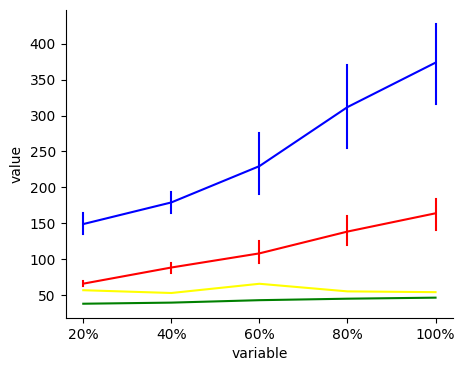

In [109]:
df = pd.DataFrame()
plt.figure(figsize=(5, 4))
for rate in [0.2, 0.4, 0.6, 0.8, 1.0]:
    df = pd.concat([
        pd.DataFrame({
            rate: [x[0] for x in run_times[rate]]
            }),
        df], axis=1)
df = df.melt()
cdf = df.copy()

s_df = pd.DataFrame({
    'variable': [1.0, 0.8, 0.6, 0.4, 0.2],
    'value': [281.1048073768616, 272.427374124527, 260.0797984600067, 239.71829557418823, 230.53460097312927] # copied from above
})
s_df.value = s_df.value / 6 # six samples
s_cdf = pd.DataFrame({
    'variable': [1.0, 0.8, 0.6, 0.4, 0.2],
})

sns.lineplot(df, x='variable', y='value', err_style='bars', color='red')
sns.lineplot(cdf, x='variable', y='value', err_style='bars', color='blue')
sns.lineplot(s_df, x='variable', y='value', err_style='bars', color='green')
sns.lineplot(s_cdf, x='variable', y='value', err_style='bars', color='yellow')
sns.despine()
plt.xticks([0.2, 0.4, 0.6, 0.8, 1.0], ['20%', '40%', '60%', '80%', '100%'])
# plt.gca().invert_xaxis()

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./supplementary_images/Global_runtime.pdf', bbox_inches='tight')